<a href="https://colab.research.google.com/github/sridevibonthu/TSAI_END_P1/blob/main/Capstone/TexttoCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer1.png)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext import data 

from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
spacy_text = spacy.load('en')

In [ ]:
def tokenize_code(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_text.tokenizer(text)]

def tokenize_text(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_text.tokenizer(text)]

In [ ]:
SRC = Field(tokenize = tokenize_text, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_code, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [ ]:
fields = [('src', SRC),('trg',TRG)]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/END/TexttoPython2.csv')
#df = pd.read_csv('TexttoPython2.csv')
df.head()

,text,sourcecode,text_length,code_length
0,write a python program to add two numbers,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...,41,61
1,write a python function to add two user provid...,"def add_two_numbers(num1, num2):\n sum = nu...",75,70
2,write a program to find and print the largest ...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= n...,65,196
3,write a program to find and print the smallest...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...,66,201
4,Write a python function to merge two given lis...,"def merge_lists(l1, l2):\n return l1 + l2\n",57,44


In [ ]:
df.shape

(4299, 4)

In [ ]:
df.describe()

,text_length,code_length
count,4299.000000,4299.000000
mean,74.481042,167.029542
std,31.772111,131.600297
min,23.000000,10.000000
25%,54.000000,78.000000
50%,68.000000,128.000000
75%,87.000000,213.500000
max,309.000000,963.000000


In [ ]:
df.columns

Index(['text', 'sourcecode', 'text_length', 'code_length'], dtype='object')

In [ ]:
df['text'][10]

'Write a python function to print powers of 2, for given number of terms'

In [ ]:
example = [torchtext.legacy.data.Example.fromlist([df.text[i], df.sourcecode[i]], fields) for i in range(df.shape[0])]

In [ ]:
Dataset = torchtext.legacy.data.Dataset(example, fields)

In [ ]:
(train_data, valid_data) = Dataset.split(split_ratio= [0.85, 0.15], random_state = random.seed(SEED))
len(train_data), len(valid_data)

(3654, 645)

In [ ]:
vars(train_data.examples[2])

{'src': ['write',
  'a',
  'program',
  'to',
  'print',
  'all',
  'the',
  'even',
  'numbers',
  'in',
  'a',
  'range'],
 'trg': ['r1',
  ',',
  'r2',
  '=',
  '1',
  ',',
  '28',
  '\n',
  'for',
  '_',
  'in',
  'range(r1',
  ',',
  'r2',
  '+',
  '1',
  ')',
  ':',
  '\n  ',
  'if',
  '_',
  '%',
  '2',
  '=',
  '=',
  '0',
  ':',
  '\n    ',
  'print',
  '(',
  '_',
  ')']}

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
temp_vec = KeyedVectors.load('vectors.kv')

In [ ]:
temp_vec.get_vector('for')

array([-2.2212107 , -3.2716973 ,  0.08596397,  1.0600432 ,  1.569161  ,
        2.6471703 ,  3.9394183 ,  1.6362194 , -1.4283733 ,  0.8181455 ,
       -0.40948525,  0.79383725, -0.20749182, -0.6079804 ,  0.67397064,
       -0.9775447 ,  0.20821586, -0.26805055, -1.3640004 ,  6.870676  ,
        1.8757685 ,  4.8799257 , -0.77709275,  2.5054526 ,  1.1443208 ,
        2.3336983 , -2.3346663 ,  0.35804844, -4.5044103 , -1.7924329 ,
       -0.78196406,  1.212055  ,  2.8979034 ,  3.057321  ,  2.6749594 ,
        4.093399  ,  1.1332434 , -0.66972274, -4.2216635 ,  3.6693451 ,
       -3.2459188 ,  1.9979509 , -2.7410555 , -1.763092  ,  3.60696   ,
        2.7205794 , -1.0839537 , -2.7054164 , -1.8759485 ,  4.9015856 ,
        1.2094648 , -0.81035155,  0.62556684, -3.4928925 , -1.5139366 ,
       -2.3137531 ,  3.1062942 , -3.185933  , -0.7376263 ,  1.6052458 ,
        2.7609344 ,  0.6255045 , -1.845184  ,  3.0349295 ,  0.27142432,
       -2.362853  , -2.560822  , -2.1509025 , -1.2535785 , -0.17

In [ ]:
trg_word2vec_vectors = []
for token, idx in tqdm_notebook(TRG.vocab.stoi.items()):
    if token in temp_vec.vocab.keys():
        trg_word2vec_vectors.append(torch.FloatTensor(temp_vec.get_vector(token)))
    else:
        trg_word2vec_vectors.append(torch.zeros(100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  after removing the cwd from sys.path.


In [ ]:
TRG.vocab.set_vectors(TRG.vocab.stoi, trg_word2vec_vectors, 100)

In [ ]:
len(SRC.vocab), len(TRG.vocab)

(1449, 5373)

In [ ]:
list(SRC.vocab.freqs.most_common(10)), list(TRG.vocab.freqs.most_common(10))

([('a', 5148),
  ('to', 3066),
  ('write', 3023),
  ('python', 2238),
  ('the', 2076),
  ('of', 1759),
  ('program', 1648),
  ('function', 1582),
  ('and', 1152),
  ('list', 1085)],
 [(')', 13657),
  ('=', 9076),
  (',', 8896),
  (':', 8680),
  ('\n', 5964),
  ('\n    ', 4745),
  ('"', 4683),
  ("'", 4310),
  (']', 4056),
  ('(', 2787)])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
BATCH_SIZE = 32

train_iterator, valid_iterator = BucketIterator.splits(
    (train_data, valid_data), 
     batch_size = BATCH_SIZE,
     sort_key = lambda x: len(x.trg),
     device = device)

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 1024):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 1024):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

10000
11000
11100
11100
11100

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,605,245 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 50
CLIP = 1
tloss = []
vloss = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'code-model.pt')
        print(".... Validation loss is decreased....Model saved ....")
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    tloss.append(train_loss)
    vloss.append(valid_loss)

.... Validation loss is decreased....Model saved ....
Epoch: 01 | Time: 0m 19s
	Train Loss: 4.970 | Train PPL: 144.016
	 Val. Loss: 3.365 |  Val. PPL:  28.922
.... Validation loss is decreased....Model saved ....
Epoch: 02 | Time: 0m 19s
	Train Loss: 3.381 | Train PPL:  29.404
	 Val. Loss: 2.783 |  Val. PPL:  16.162
.... Validation loss is decreased....Model saved ....
Epoch: 03 | Time: 0m 19s
	Train Loss: 2.858 | Train PPL:  17.430
	 Val. Loss: 2.446 |  Val. PPL:  11.537
.... Validation loss is decreased....Model saved ....
Epoch: 04 | Time: 0m 19s
	Train Loss: 2.480 | Train PPL:  11.947
	 Val. Loss: 2.217 |  Val. PPL:   9.179
.... Validation loss is decreased....Model saved ....
Epoch: 05 | Time: 0m 19s
	Train Loss: 2.173 | Train PPL:   8.783
	 Val. Loss: 2.059 |  Val. PPL:   7.838
.... Validation loss is decreased....Model saved ....
Epoch: 06 | Time: 0m 19s
	Train Loss: 1.919 | Train PPL:   6.812
	 Val. Loss: 1.886 |  Val. PPL:   6.590
.... Validation loss is decreased....Model sav

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, type(str)):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

src = ' '.join(src)
trg = ' '.join(trg)

print(f'src = {src}')
print(f'trg = {trg}')

src = write a python program to convert each list element to key - value pair . print the final dictionary
trg =   
 test_list = [ 2323 , 82 , 129388 , 234 , 95 ] 
  
 print("the original list is : " + str(test_list ) ) 
  
 res = dict ( ) 
 for ele in test_list : 
  
     mid_idx = len(str(ele ) ) // 2 
     key = int(str(ele)[:mid_idx ] ) 
     val = int(str(ele)[mid_idx : ] ) 
  
     res[key ] = val 
  
 print("constructed dictionary : " + str(res ) )


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
str = ' '.join(translation)
print("The predicted target in code form : \n", str)

predicted trg = ['  \n', 'test_list', '=', '[', '2323', ',', '82', ',', '129388', ',', '234', ',', '95', ']', '\n  \n', 'print("the', 'original', 'list', 'is', ':', '"', '+', 'str(test_list', ')', ')', '\n  \n', 'res', '=', 'dict', '(', ')', '\n', 'for', 'ele', 'in', 'test_list', ':', '\n  \n    ', 'mid_idx', '=', 'len(str(ele', ')', ')', '//', '2', '\n    ', 'key', '=', 'int(str(ele)[:mid_idx', ']']
The predicted target in code form : 
   
 test_list = [ 2323 , 82 , 129388 , 234 , 95 ] 
  
 print("the original list is : " + str(test_list ) ) 
  
 res = dict ( ) 
 for ele in test_list : 
  
     mid_idx = len(str(ele ) ) // 2 
     key = int(str(ele)[:mid_idx ]


In [ ]:
str = ' '.join(translation)
print("The predicted target in code form : \n", str)

The predicted target in code form : 
   
 test_list = [ 2323 , 82 , 129388 , 234 , 95 ] 
  
 print("the original list is : " + str(test_list ) ) 
  
 res = dict ( ) 
 for ele in test_list : 
  
     mid_idx = len(str(ele ) ) // 2 
     key = int(str(ele)[:mid_idx ]


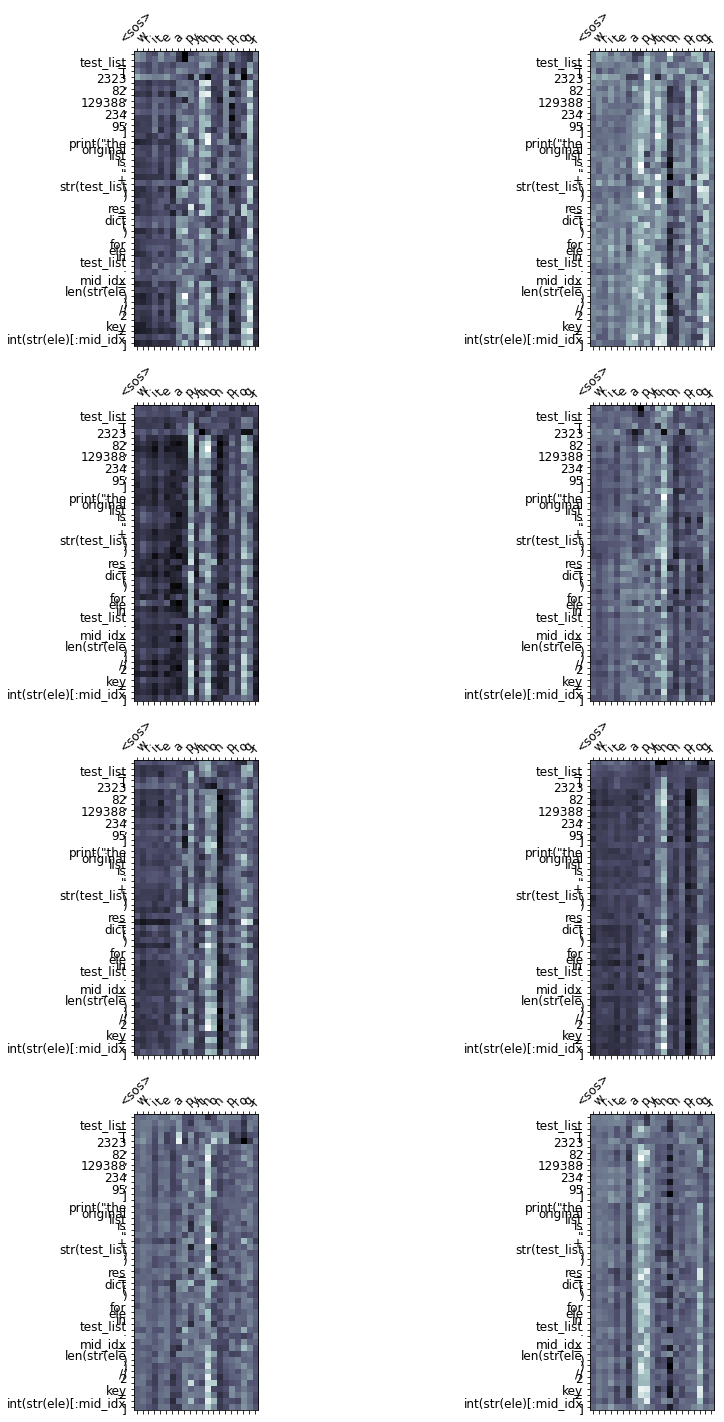

In [ ]:
display_attention(src, translation, attention)


In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
src = ' '.join(src)
trg = ' '.join(trg)
print(f'src = {src}')
print(f'trg = {trg}')

src = write a function to create all possible permutations from a given collection of distinct numbers
trg = def permute(nums ) : 
   result_perms = [ [ ] ] 
   for n in nums : 
     new_perms = [ ] 
     for perm in result_perms : 
       for i in range(len(perm)+1 ) : 
         new_perms.append(perm[:i ] + [ n ] + perm[i : ] ) 
         result_perms = new_perms 
   return result_perms


In [ ]:

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
str = ' '.join(translation)
print("The predicted target in code form : \n", str)

predicted trg = ['def', 'permute(nums', ')', ':', '\n  ', 'result_perms', '=', '[', '[', ']', ']', '\n  ', 'for', 'n', 'in', 'nums', ':', '\n    ', 'new_perms', '=', '[', ']', '\n    ', 'for', 'perm', 'in', 'result_perms', ':', '\n      ', 'for', 'i', 'in', 'range(len(perm)+1', ')', ':', '\n        ', 'new_perms.append(perm[:i', ']', '+', 'perm[i', ':', ']', ')', '\n        ', 'result_perms', '=', 'new_perms', '\n  ', 'return', 'result_perms']
The predicted target in code form : 
 def permute(nums ) : 
   result_perms = [ [ ] ] 
   for n in nums : 
     new_perms = [ ] 
     for perm in result_perms : 
       for i in range(len(perm)+1 ) : 
         new_perms.append(perm[:i ] + perm[i : ] ) 
         result_perms = new_perms 
   return result_perms


In [ ]:
example_idx = 36

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
src = ' '.join(src)
trg = ' '.join(trg)
print(f'src = {src}')
print(f'Original code = {trg}')


translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'----\n\npredicted trg = {translation}')
str = ' '.join(translation)
print("The predicted target in code form : \n", str)


src = 50 write a program to display the multiplication table of a number
Original code = num = int(input("show the multiplication table of ? ") )  
----

predicted trg = ['num', '=', '12', '\n', 'for', 'i', 'in', 'range(1', ',', '11', ')', ':', '\n   ', 'print(num', ',', "'", 'x', "'", ',', 'i', ',', "'", '=', "'", ',', 'num*i', ')', '<eos>']
The predicted target in code form : 
 num = 12 
 for i in range(1 , 11 ) : 
    print(num , ' x ' , i , ' = ' , num*i ) <eos>


In [ ]:
example_idx = 101

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
src = ' '.join(src)
trg = ' '.join(trg)
print(f'src = {src}')
print(f'Original code = {trg}')


translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'----\n\npredicted trg = {translation}')
str = ' '.join(translation)
print("The predicted target in code form : \n", str)


src = write a python program to generate gray codes using recursion
Original code = def get_gray_codes(n ) : 
     " " " return n - bit gray code in a list . " " " 
     if n = = 0 : 
         return [ '' ] 
     first_half = get_gray_codes(n - 1 ) 
     second_half = first_half.copy ( ) 
 
     first_half = [ ' 0 ' + code for code in first_half ] 
     second_half = [ ' 1 ' + code for code in reversed(second_half ) ] 
 
     return first_half + second_half
----

predicted trg = ['def', 'get_gray_codes(n', ')', ':', '\n    ', 'if', 'n', '=', '=', '0', ':', '\n        ', 'return', '[', "''", ']', '\n    ', 'first_half', '=', 'get_gray_codes(n', '-', '1', ')', '\n    ', 'second_half', '=', '<unk>', '(', ')', '\n \n    ', 'first_half', '=', '[', "'", '0', "'", '+', 'code', 'for', 'code', 'in', 'first_half', ']', '\n    ', 'second_half', '=', '[', "'", '1', "'"]
The predicted target in code form : 
 def get_gray_codes(n ) : 
     if n = = 0 : 
         return [ '' ] 
     first_half = get_

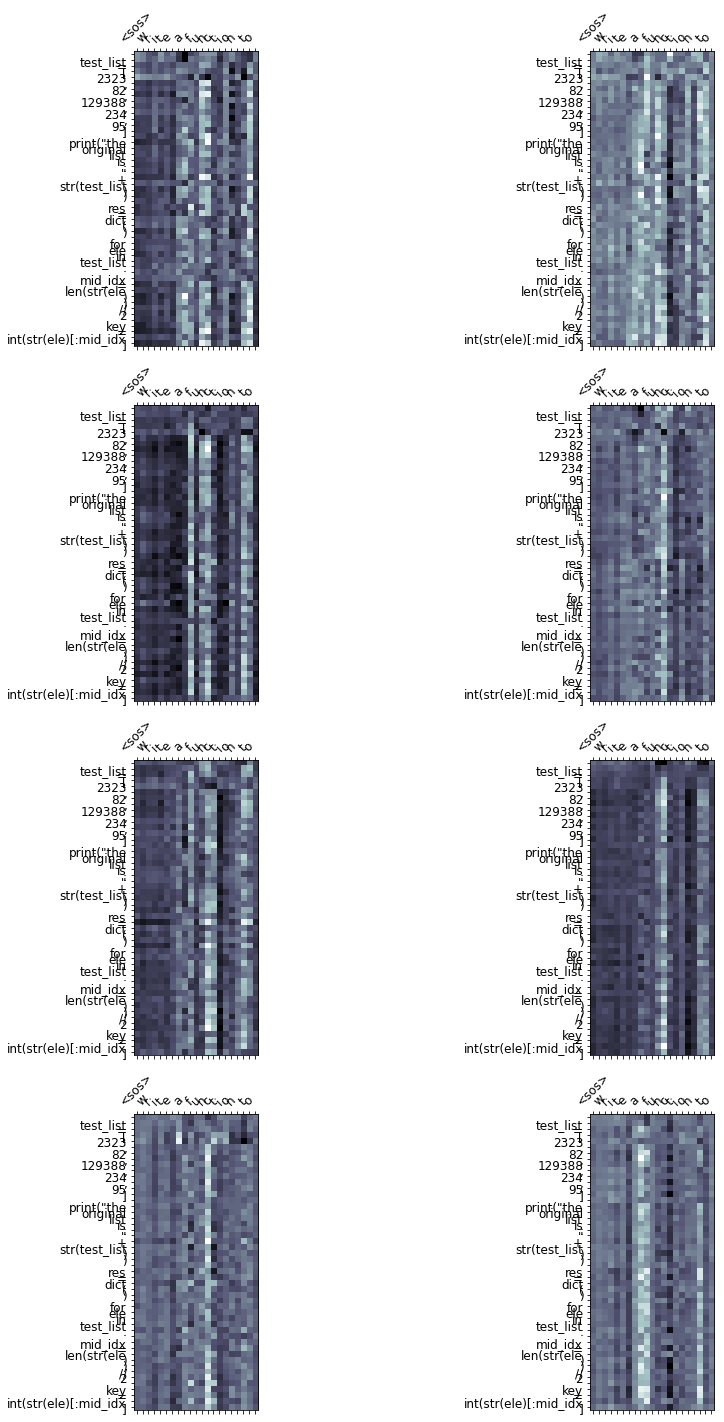

In [ ]:
display_attention(src, translation, attention)


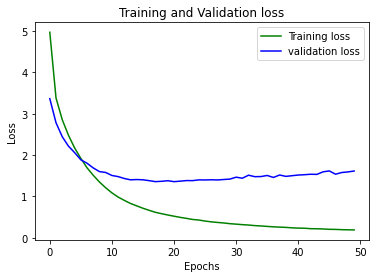

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tloss, 'g', label='Training loss')
plt.plot(vloss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append(trg)

        
    #print(pred_trg.shape, trgs.shape)
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(valid_data[:100], SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')